In [1]:
import pickle
import os
import pandas as pd
from datetime import datetime
from collections import Counter
# import hail as hl
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
save_path = '../datasets/demog.csv'
demog = pd.read_csv(save_path)

In [3]:
demog['date_of_birth'] = pd.to_datetime(demog['date_of_birth'], errors = 'coerce')

In [5]:
len(demog['person_id'].unique())

50000

In [6]:
Counter(demog['group'])

Counter({'control': 48600, 'MSH2': 364, 'MLH1': 361, 'MSH6': 348, 'PMS2': 327})

In [7]:
ages = {}
status = {}
bd = {}
for i,row in tqdm(demog.iterrows(), total = demog.shape[0]):
    ages[row['person_id']] = row['age']
    status[row['person_id']] = row['group']
    bd[row['person_id']] = row['date_of_birth']

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:03<00:00, 14744.59it/s]


In [8]:
mlh1_pat = list(demog[demog['group']=='MLH1'].person_id)
msh2_pat = list(demog[demog['group']=='MSH2'].person_id)
msh6_pat = list(demog[demog['group']=='MSH6'].person_id)
pms2_pat = list(demog[demog['group']=='PMS2'].person_id)

In [9]:
mmr = list(set(mlh1_pat + msh2_pat + msh6_pat + pms2_pat))

In [10]:
len(mmr)

1400

In [11]:
# pip install openpyxl

In [12]:
agg_df = pd.read_excel('../datasets/Supplementary Table 2.xlsx')
agg_df = agg_df[['cancer_names','category']]
agg = {}
for i, row in agg_df.iterrows():
    agg[row['cancer_names']] = row['category']

c:\Users\jp4147\Anaconda3\envs\py39new\lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: Sheet1!$A:$B.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


In [13]:
cat = list(agg_df.category.unique())

# cancer conditions for case and control

In [14]:
cancer = pd.read_csv('../datasets/cancer.csv')

In [15]:
cancer['condition_start_date'] = pd.to_datetime(cancer['condition_start_date'], errors = 'coerce')

In [16]:
case_ctrl_cancer = cancer[['person_id','condition_start_date','category','group']]

In [17]:
len(case_ctrl_cancer)

25000

In [18]:
len(case_ctrl_cancer['person_id'].unique())

25000

In [19]:
case_ctrl_cancer_demog = case_ctrl_cancer.merge(demog[['person_id']], on = 'person_id', how = 'inner')

In [20]:
len(case_ctrl_cancer_demog)

25000

# LS associated cancers

In [21]:
LScancer = ['colon/rectal','stomach','small intestine', 'uterine/endometrial','ovarian','hepatobiliary','urinary tract/bladder',
         'pancreas', 'prostate']

In [22]:
case_ctrl_LScancer = case_ctrl_cancer_demog[case_ctrl_cancer_demog['category'].isin(LScancer)]

In [23]:
ctrl_LScancer = case_ctrl_LScancer[case_ctrl_LScancer['group'] == 'control']
case_LScancer = case_ctrl_LScancer[case_ctrl_LScancer['group'] != 'control']

In [24]:
print(len(ctrl_LScancer))
print(len(ctrl_LScancer['person_id'].unique()))

print(len(case_LScancer))
print(len(case_LScancer['person_id'].unique()))

7073
7073
204
204


In [25]:
Counter(case_LScancer['category'])

Counter({'prostate': 31,
         'colon/rectal': 28,
         'uterine/endometrial': 26,
         'small intestine': 25,
         'pancreas': 22,
         'urinary tract/bladder': 19,
         'ovarian': 18,
         'stomach': 18,
         'hepatobiliary': 17})

In [26]:
Counter(ctrl_LScancer['category'])

Counter({'urinary tract/bladder': 828,
         'pancreas': 810,
         'uterine/endometrial': 800,
         'hepatobiliary': 796,
         'colon/rectal': 786,
         'prostate': 784,
         'stomach': 763,
         'ovarian': 761,
         'small intestine': 745})

In [27]:
def LScancer_num(dat, num_cancer = 1):
    grk = dat.groupby('person_id')
    patids = list(dat['person_id'].unique())

    can1, can2, can3plus = [], [], []
    for i in patids:
        count = len(grk.get_group(i))
        if count==1:
            can1.append(i)
        elif count==2:
            can2.append(i)
        else:
            can3plus.append(i)

    print('1 LS cancer:', len(can1))
    print('2 LS cancer:', len(can2))
    print('>=3 LS cancer:', len(can3plus))
    
    if num_cancer == 1:
        num_can = can1
    elif num_cancer ==2:
        num_can = can2
    else:
        num_can = can3plus
        
    data_of_interest = demog[demog['person_id'].isin(num_can)]['age']
    print('current age median:', np.median(data_of_interest))
    print('current age min:',np.min(data_of_interest))
    print('current age max:',np.max(data_of_interest))

    ageAtd = []
    for i, row in dat.iterrows():
        delta = row['condition_start_date'] - bd[row['person_id']]
        age_at_diag = delta.days / 365.25  # Convert days to years
        ageAtd.append(age_at_diag)

    dat.loc[:,'age_at_diag'] = ageAtd
    data_of_interest = dat[dat['person_id'].isin(num_can)]['age_at_diag']
    print('age at diag median:',np.median(data_of_interest))
    print('age at diag min:',np.min(data_of_interest))
    print('age at diag max:', np.max(data_of_interest))

In [28]:
case_LScancer

,person_id,condition_start_date,category,group
1,8,2019-03-20,pancreas,MSH6
3,10,1991-03-07,small intestine,MSH6
4,13,2001-02-11,hepatobiliary,PMS2
8,28,1981-01-15,prostate,MSH6
19,49,2003-07-20,urinary tract/bladder,MLH1
...,...,...,...,...
683,1340,1991-05-08,urinary tract/bladder,PMS2
691,1357,1983-12-03,prostate,MLH1
693,1363,2018-07-10,ovarian,PMS2
695,1371,2005-05-24,urinary tract/bladder,MSH2


In [29]:
LScancer_num(case_LScancer)

1 LS cancer: 204
2 LS cancer: 0
>=3 LS cancer: 0
current age median: 61.0
current age min: 20
current age max: 100
age at diag median: 61.37987679671458
age at diag min: 9.809719370294319
age at diag max: 110.48049281314168


C:\Users\jp4147\AppData\Local\Temp\ipykernel_54572\2532470111.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:,'age_at_diag'] = ageAtd


In [30]:
LScancer_num(ctrl_LScancer)

1 LS cancer: 7073
2 LS cancer: 0
>=3 LS cancer: 0
current age median: 61.0
current age min: 20
current age max: 100
age at diag median: 61.79603011635866
age at diag min: 8.386036960985626
age at diag max: 116.28473648186174


C:\Users\jp4147\AppData\Local\Temp\ipykernel_54572\2532470111.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[:,'age_at_diag'] = ageAtd


In [31]:
# LScancer_num(pd.concat([case_LScancer, ctrl_LScancer]))

In [32]:
# LScancer_num(pd.concat([case_LScancer, ctrl_LScancer]), num_cancer=2)

In [33]:
# LScancer_num(pd.concat([case_LScancer, ctrl_LScancer]), num_cancer = 3)

In [34]:
# ctrl_LScancer[ctrl_LScancer['age_at_diag']<18]

# nonLS associated cancers

In [35]:
case_ctrl_nonLScancer = case_ctrl_cancer[~case_ctrl_cancer['category'].isin(LScancer)]

In [36]:
case_ctrl_nonLScancer

,person_id,condition_start_date,category,group
0,6,2004-06-06,malignant mast cell tumor (clinical),MSH6
2,9,2017-04-26,esophagus,MSH2
5,18,2000-05-11,breast,MLH1
6,21,2005-01-27,brain,MSH6
7,26,2006-07-15,kidney,PMS2
...,...,...,...,...
24991,49935,2002-05-04,brain,control
24992,49936,2022-06-03,oropharyngeal,control
24993,49937,2016-04-22,neuroendocrine,control
24995,49941,2013-01-05,bone/limb,control


In [37]:
case_ctrl_nonLScancer = case_ctrl_nonLScancer.merge(demog[['person_id']], on = 'person_id', how = 'inner')

In [38]:
case_nonLScancer = case_ctrl_nonLScancer[case_ctrl_nonLScancer['group']!='control']
ctrl_nonLScancer = case_ctrl_nonLScancer[case_ctrl_nonLScancer['group']=='control']

In [39]:
print(len(case_nonLScancer['person_id'].unique()))
print(len(ctrl_nonLScancer['person_id'].unique()))

496
17227


In [40]:
print(len(set(list(case_nonLScancer['person_id'].unique()))-set(list(case_LScancer['person_id'].unique()))))
print(len(set(list(ctrl_nonLScancer['person_id'].unique()))-set(list(ctrl_LScancer['person_id'].unique()))))

496
17227


# Table 1 statistics

### Z test

In [76]:
# use a Z-test for proportions when your primary goal is to compare the proportion of a single characteristic between 
# two groups. Use a Chi-squared test when you want to examine the relationship or association between 
# two categorical variables, often represented in a contingency table.

In [77]:
import statsmodels.api as sm

In [78]:
# Sample data
count = [303, 97108]  # Number of successes (e.g., number of males) in each group
nobs = [457, 162513]   # Total number of observations in each group

z, p = sm.stats.proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-statistic: {z}")
print(f"P-value: {p}")

alpha = 0.05
if p < alpha:
    print("The proportions of gender between the two groups are statistically significantly different.")
else:
    print("There's no statistically significant difference in gender proportions between the groups.")

Z-statistic: 2.850645414834033
P-value: 0.004363059493622227
The proportions of gender between the two groups are statistically significantly different.


### Chi squred and odds ratio

In [79]:
import numpy as np
from scipy.stats import chi2_contingency

# Example data: [Cancer, No Cancer]
# c_tot = 457
# nc_tot = 162513

# c=52
# nc = 7457

c_tot = 268
nc_tot = 100408

c=25
nc = 957

# c_tot = 237
# nc_tot = 81221

# c=34
# nc = 2107

data = np.array([
    [nc, nc_tot-nc],  # Non-carriers
    [c, c_tot-c]    # Carriers
])

# Calculate the odds ratio
odds_ratio = (c * (nc_tot-nc)) / ((c_tot-c) * nc)

# Calculate the 95% confidence interval for the odds ratio
se_log_or = np.sqrt(1/c + 1/(c_tot-c) + 1/nc + 1/(nc_tot-nc))
ci_lower = np.exp(np.log(odds_ratio) - 1.96 * se_log_or)
ci_upper = np.exp(np.log(odds_ratio) + 1.96 * se_log_or)

print(f"Odds Ratio: {odds_ratio}")
print(f"95% Confidence Interval: [{ci_lower}, {ci_upper}]")

# Perform Chi-square test
chi2, pvalue, dof, expected = chi2_contingency(data)

print(f"chi2: {chi2}")
print(f"pvalue: {pvalue}")
# print(f"Degrees of Freedom: {dof}")
# print("Expected Frequencies:")
# print(expected)

Odds Ratio: 10.691310723239203
95% Confidence Interval: [7.048867302884564, 16.215956418143037]
chi2: 185.5339981929277
pvalue: 3.000699124274894e-42


# cumulative probability of having cancer

In [42]:
ageAtd = []
for i, row in case_ctrl_cancer_demog.iterrows():
    delta = row['condition_start_date'] - bd[row['person_id']]
    age_at_diag = delta.days / 365.25  # Convert days to years
    ageAtd.append(age_at_diag)

case_ctrl_cancer_demog.loc[:,'age_at_diag'] = ageAtd

In [43]:
case_ctrl_cancer_demog

,person_id,condition_start_date,category,group,age_at_diag
0,6,2004-06-06,malignant mast cell tumor (clinical),MSH6,57.418207
1,8,2019-03-20,pancreas,MSH6,105.336071
2,9,2017-04-26,esophagus,MSH2,110.707734
3,10,1991-03-07,small intestine,MSH6,19.091034
4,13,2001-02-11,hepatobiliary,PMS2,86.579055
...,...,...,...,...,...
24995,49941,2013-01-05,bone/limb,control,41.390828
24996,49942,1991-01-30,urinary tract/bladder,control,84.257358
24997,49943,1986-10-10,pancreas,control,18.266940
24998,49945,1983-10-28,mediastinum,control,23.594798


In [44]:
len(case_ctrl_cancer_demog['person_id'].unique())

25000

In [45]:
case_ctrl_LScancer = case_ctrl_cancer_demog[case_ctrl_cancer_demog['category'].isin(LScancer)]

In [46]:
# first cancer only
def first_cancer(dat):
    grk = dat.groupby('person_id')
    patids = list(dat['person_id'].unique())
    first_cancer = []
    for i in tqdm(patids):
        dat = grk.get_group(i)
        dat = dat.sort_values(by='age_at_diag').iloc[0,:]
        first_cancer.append(dat)
    return pd.DataFrame(first_cancer)

In [47]:
case_ctrl_LScancer = case_ctrl_LScancer[['person_id']].merge(case_ctrl_cancer_demog, on='person_id', how = 'inner')

In [48]:
LScancer_group = first_cancer(case_ctrl_LScancer)

100%|██████████| 7277/7277 [00:04<00:00, 1801.15it/s]


In [49]:
len(LScancer_group)

7277

In [50]:
nonLScancer_patids = list(set(list(case_ctrl_cancer_demog['person_id'].unique()))-set(list(LScancer_group.person_id)))

In [51]:
len(nonLScancer_patids)

17723

In [52]:
nonLScancer_patids = pd.DataFrame(nonLScancer_patids)
nonLScancer_patids.columns = ['person_id']
nonLScancer_group = first_cancer(nonLScancer_patids.merge(case_ctrl_cancer_demog, on='person_id', how = 'inner'))

100%|██████████| 17723/17723 [00:10<00:00, 1771.95it/s]


In [53]:
len(nonLScancer_group)

17723

In [54]:
all_cancer_group = pd.concat([LScancer_group, nonLScancer_group])

In [55]:
Counter(LScancer_group['group'])

Counter({'control': 7073, 'MLH1': 66, 'MSH2': 48, 'MSH6': 45, 'PMS2': 45})

In [56]:
def cumulative_prob(dat):
    frequency = dat['age_at_diag'].value_counts().sort_index()
    cumulative_frequency = frequency.cumsum()
    cumulative_probability = cumulative_frequency / cumulative_frequency.iloc[-1]
    return cumulative_probability 

In [57]:
age_diag = all_cancer_group[all_cancer_group['group']!='control']
age_diag_control = all_cancer_group[all_cancer_group['group']=='control']

print(len(age_diag))
print(len(age_diag_control))

700
24300


In [58]:
print(np.median(age_diag['age_at_diag']))
print(np.median(age_diag_control['age_at_diag']))

59.83436002737851
62.20260095824777


LS carrier
at age50 0.3142857142857143
at age65 0.5685714285714286
nonLS carrier
at age50 0.32069958847736624
at age65 0.539835390946502


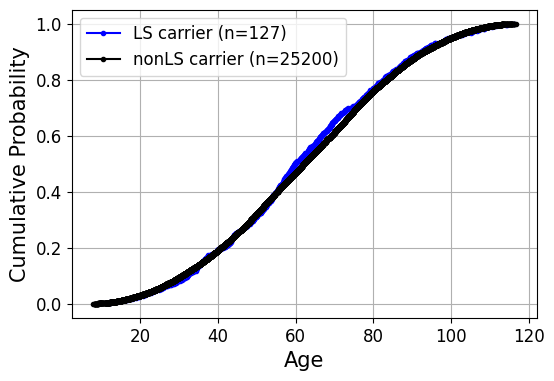

In [59]:
plt.figure(figsize=(6,4))

cumulative_probability = cumulative_prob(age_diag)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'b', label = 'LS carrier (n=127)')
print('LS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age65', cumulative_probability[cumulative_probability.index <= 65].iloc[-1])

cumulative_probability = cumulative_prob(age_diag_control)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'k', label = 'nonLS carrier (n=25200)')
print('nonLS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age65', cumulative_probability[cumulative_probability.index <= 65].iloc[-1])

plt.xlabel('Age', fontsize = 15)
plt.ylabel('Cumulative Probability', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('All cancers', fontsize = 15)

plt.grid(True)
plt.legend(fontsize = 12)
plt.show()

nonLS carrier
at age50 0.32069958847736624
at age70 0.6111522633744856
MLH1
at age50 0.26842105263157895
at age70 0.6
MSH2
at age50 0.2967032967032967
at age70 0.6263736263736264
MSH6
at age50 0.3333333333333333
at age70 0.65
PMS2
at age50 0.3716216216216216
at age70 0.7567567567567568


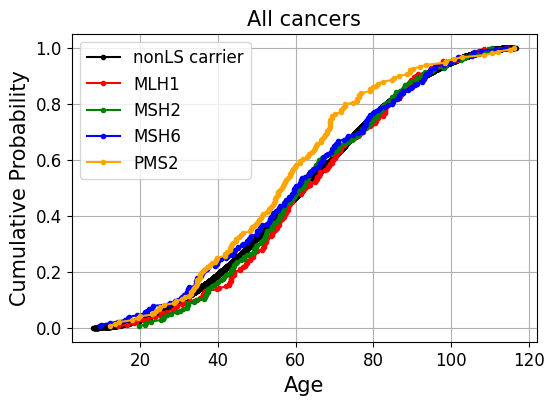

In [60]:
plt.figure(figsize=(6,4))

cumulative_probability = cumulative_prob(age_diag_control)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'k', label = 'nonLS carrier')
print('nonLS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age70', cumulative_probability[cumulative_probability.index <= 70].iloc[-1])

col = ['r', 'g', 'b', 'orange']
ii=0
for i in ['MLH1','MSH2','MSH6','PMS2']:
    cumulative_probability = cumulative_prob(age_diag[age_diag['group']==i])
    plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', label = i, color = col[ii])
    print(i)
    print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
    print('at age70', cumulative_probability[cumulative_probability.index <= 70].iloc[-1])
    ii=ii+1
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Cumulative Probability', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('All cancers', fontsize = 15)

plt.grid(True)
plt.legend(fontsize = 12)
plt.show()

### by LS cancers

In [61]:
age_diag = LScancer_group[LScancer_group['group']!='control']
age_diag_control = LScancer_group[LScancer_group['group']=='control']

In [62]:
print(np.median(age_diag['age_at_diag']))
print(np.median(age_diag_control['age_at_diag']))

61.37987679671458
61.79603011635866


In [63]:
print(len(age_diag))
print(len(age_diag_control))

204
7073


LS carrier
at age50 0.28921568627450983
at age65 0.5588235294117647
nonLS carrier
at age50 0.32447334935670863
at age70 0.6123285734483246


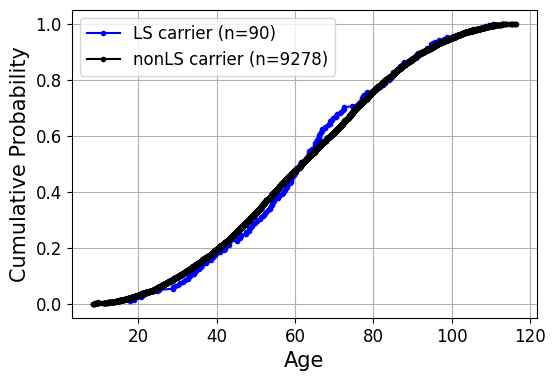

In [64]:
plt.figure(figsize=(6,4))

cumulative_probability = cumulative_prob(age_diag)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'b', label = 'LS carrier (n=90)')
print('LS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age65', cumulative_probability[cumulative_probability.index <= 65].iloc[-1])

cumulative_probability = cumulative_prob(age_diag_control)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'k', label = 'nonLS carrier (n=9278)')
print('nonLS carrier')
print('at age50', cumulative_probability[cumulative_probability.index <= 50].iloc[-1])
print('at age70', cumulative_probability[cumulative_probability.index <= 70].iloc[-1])

plt.xlabel('Age', fontsize = 15)
plt.ylabel('Cumulative Probability', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.legend(fontsize = 12)

plt.show()

nonLS carrier
at age50 0.32447334935670863
at age70 0.6123285734483246
MLH1
at age50 0.24242424242424243
at age70 0.6212121212121212
MSH2
at age50 0.20833333333333334
at age70 0.6041666666666666
MSH6
at age50 0.26666666666666666
at age70 0.6222222222222222
PMS2
at age50 0.4666666666666667
at age70 0.8222222222222222


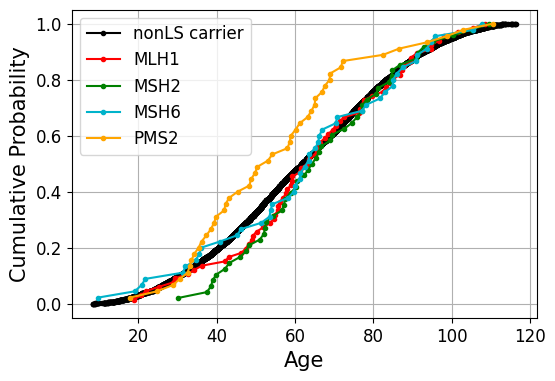

In [65]:
plt.figure(figsize=(6,4))

cumulative_probability = cumulative_prob(age_diag_control)
plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', color = 'k', label = 'nonLS carrier')
print('nonLS carrier')
print('at age50', cumulative_probability[cumulative_probability.index < 50].iloc[-1])
print('at age70', cumulative_probability[cumulative_probability.index <70].iloc[-1])

num = [18,17,29,21]
col = ['r', 'g', '#00b3ca', 'orange']

ii=0
for i in ['MLH1','MSH2','MSH6','PMS2']:
    cumulative_probability = cumulative_prob(age_diag[age_diag['group']==i])
    plt.plot(cumulative_probability.index, cumulative_probability.values, marker='.', label = i, color = col[ii])
    print(i)
    print('at age50', cumulative_probability[cumulative_probability.index < 50].iloc[-1])
    print('at age70', cumulative_probability[cumulative_probability.index <70].iloc[-1])
    ii=ii+1
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Cumulative Probability', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.legend(fontsize = 12)
# plt.title(cancer[ii], fontsize = 15)
# plt.title('LS-associated cancers', fontsize = 15)
plt.show()

# survival analysis

In [66]:
# pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from itertools import combinations

kmf = KaplanMeierFitter()

In [67]:
col = ['r', 'g', '#00b3ca', 'orange']
def plot_surv(dat, p ='P<0.0001', p1 = 'P<0.0001', p2= 'P<0.0001', p3= 'P<0.0001', p4= 'P<0.0001'):
    lst = list(dat['age_at_diag'])
    event = [1 if not np.isnan(x) else 0 for x in lst]

    time2event = [a2 if not np.isnan(a2) else a1 for a1, a2 in zip(dat['age'], dat['age_at_diag'])]

    dat['event'] = event
    dat['time_to_event'] = time2event

    plt.figure(figsize=(6,4))

    mask_ls = dat['group'] != 'control'
    kmf.fit(dat['time_to_event'][mask_ls], event_observed=dat['event'][mask_ls], label='LS Carrier' +', '+p)
    ax = kmf.plot(ci_show=True, show_censors = True, ci_legend = True, color = 'b')

    # # For non-carriers
    mask_non_carrier = dat['group'] == 'control'
    kmf.fit(dat['time_to_event'][mask_non_carrier], event_observed=dat['event'][mask_non_carrier], label='Non-Carrier')
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color ='k')

    plt.ylabel("DFS", fontsize = 15)
    plt.xlabel("Age", fontsize = 15)
    plt.xlim([-5,100])
    plt.ylim([0,1.05])

    plt.legend(fontsize = 12)
    plt.show()

    plt.figure(figsize=(6,4))

    ###################################################################################
    mask_non_carrier = dat['group'] == 'control'
    kmf.fit(dat['time_to_event'][mask_non_carrier], event_observed=dat['event'][mask_non_carrier], label='Non-Carrier')
    ax = kmf.plot(ci_show=True, show_censors = True, ci_legend = True, color = 'k')

    mask_mlh1 = dat['group'] == 'MLH1'
    kmf.fit(dat['time_to_event'][mask_mlh1], event_observed=dat['event'][mask_mlh1], label='MLH1' +', '+p1)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[0])

    mask_msh2 = dat['group'] == 'MSH2'
    kmf.fit(dat['time_to_event'][mask_msh2], event_observed=dat['event'][mask_msh2], label='MSH2' +', '+p2)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[1])

    mask_msh6 = dat['group'] == 'MSH6'
    kmf.fit(dat['time_to_event'][mask_msh6], event_observed=dat['event'][mask_msh6], label='MSH6' +', '+p3)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[2])

    mask_pms2 = dat['group'] == 'PMS2'
    kmf.fit(dat['time_to_event'][mask_pms2], event_observed=dat['event'][mask_pms2], label='PMS2' +', '+p4)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[3])

    plt.ylabel("DFS", fontsize = 15)
    plt.xlabel("Age", fontsize = 15)
    plt.xlim([-5,100])
    plt.ylim([0,1.05])

    plt.legend(fontsize = 12)
    plt.show()
    
    results_ = logrank_test(dat['time_to_event'][mask_ls], dat['time_to_event'][mask_non_carrier], 
                       event_observed_A=dat['event'][mask_ls], event_observed_B=dat['event'][mask_non_carrier])
    
    p_value = results_.p_value
    print(f"P-value: {p_value}")
    
    df = dat.copy(deep = True)
    genes = df['group'].unique()
    for (gene1, gene2) in combinations(genes, 2):
        results = logrank_test(
            df['time_to_event'][df['group'] == gene1], 
            df['time_to_event'][df['group'] == gene2], 
            event_observed_A=df['event'][df['group'] == gene1], 
            event_observed_B=df['event'][df['group'] == gene2]
        )
        print(f"Comparison between {gene1} and {gene2}: p = {results.p_value}")
    return results_

### all cancer

In [80]:
data_surv = demog.merge(all_cancer_group[['person_id', 'age_at_diag']], on = 'person_id', how = 'outer')

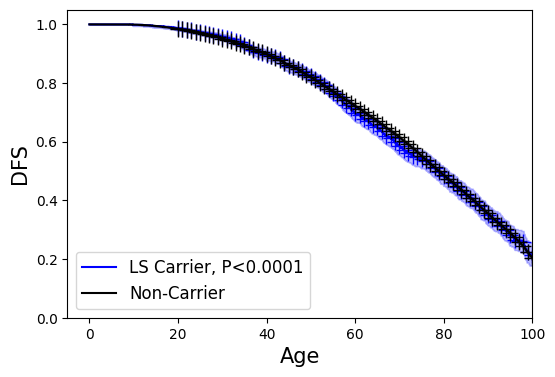

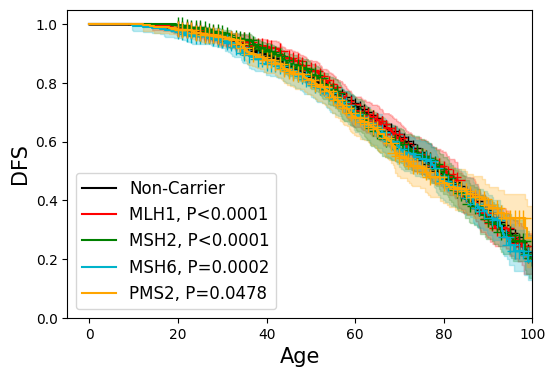

P-value: 0.9758247734117322
Comparison between MSH6 and MSH2: p = 0.7126750929376201
Comparison between MSH6 and PMS2: p = 0.3824550975687314
Comparison between MSH6 and MLH1: p = 0.4264216276504702
Comparison between MSH6 and control: p = 0.44578222759685027
Comparison between MSH2 and PMS2: p = 0.6195294686079296
Comparison between MSH2 and MLH1: p = 0.82287234431632
Comparison between MSH2 and control: p = 0.8936142921626276
Comparison between PMS2 and MLH1: p = 0.8459479674525472
Comparison between PMS2 and control: p = 0.5251525520413747
Comparison between MLH1 and control: p = 0.8291573851403993


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.98      0.04

In [81]:
plot_surv(data_surv, p3 = 'P=0.0002', p4 = 'P=0.0478')

### LS cancer

In [82]:
# Counter(LScancer_group['category']) #individuals diagnosed with LScancer may also have other cancers before or after

In [83]:
no_cancer_group = data_surv[data_surv['event']==0][list(demog.columns)]

In [84]:
data_surv_LS = pd.concat([no_cancer_group[['person_id','age','group']], LScancer_group[['person_id','group','age_at_diag']]])

In [85]:
Counter(data_surv_LS['group'])

Counter({'control': 31373, 'MLH1': 237, 'MSH2': 230, 'PMS2': 224, 'MSH6': 213})

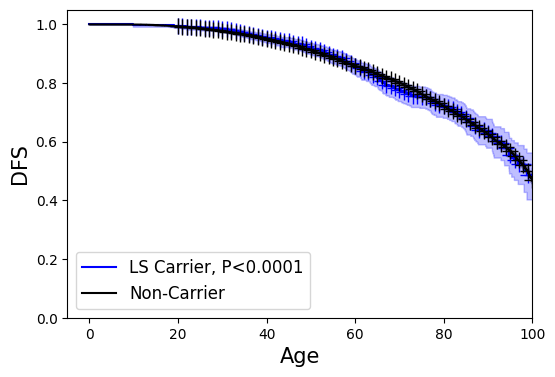

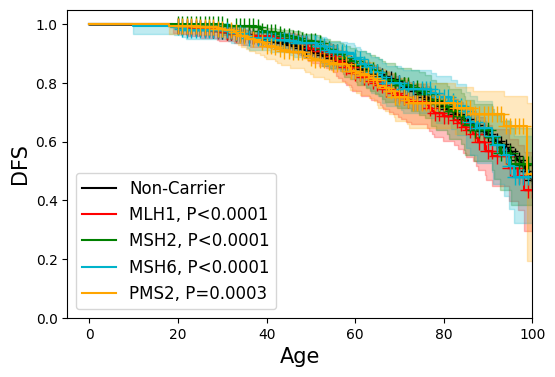

P-value: 0.9152489257923612
Comparison between MSH2 and MLH1: p = 0.33421288888849615
Comparison between MSH2 and PMS2: p = 0.9683245869860441
Comparison between MSH2 and MSH6: p = 0.8882143360192285
Comparison between MSH2 and control: p = 0.6861943744409215
Comparison between MLH1 and PMS2: p = 0.32972209594646956
Comparison between MLH1 and MSH6: p = 0.5188661861835399
Comparison between MLH1 and control: p = 0.2974350875579318
Comparison between PMS2 and MSH6: p = 0.9051589930858653
Comparison between PMS2 and control: p = 0.7378386108483864
Comparison between MSH6 and control: p = 0.8543015719352471


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.92      0.13

In [87]:
plot_surv(data_surv_LS, p4 = 'P=0.0003')

### LS cancer types

In [88]:
LScancer

['colon/rectal',
 'stomach',
 'small intestine',
 'uterine/endometrial',
 'ovarian',
 'hepatobiliary',
 'urinary tract/bladder',
 'pancreas',
 'prostate']

In [89]:
crc = LScancer_group[LScancer_group['category']=='colon/rectal']
ue = LScancer_group[LScancer_group['category']=='uterine/endometrial']
crc_ue = pd.concat([crc, ue])
others = LScancer_group.merge(crc_ue, on=list(crc.columns), how='outer', indicator=True)

# Keep only rows present in the original DataFrame and not in the sub-DataFrame
others = others[others['_merge'] == 'left_only'].drop(columns=['_merge'])

In [90]:
print(len(LScancer_group))
print(len(crc))
print(len(ue))
print(len(others))

7277
814
826
5637


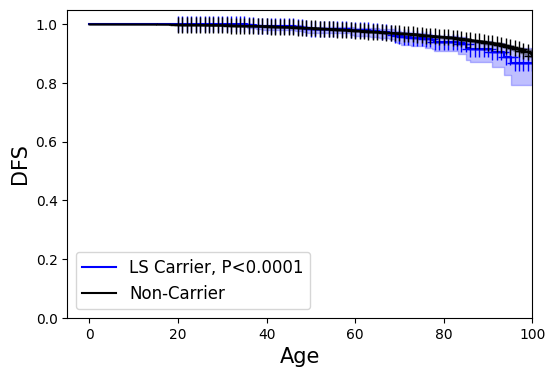

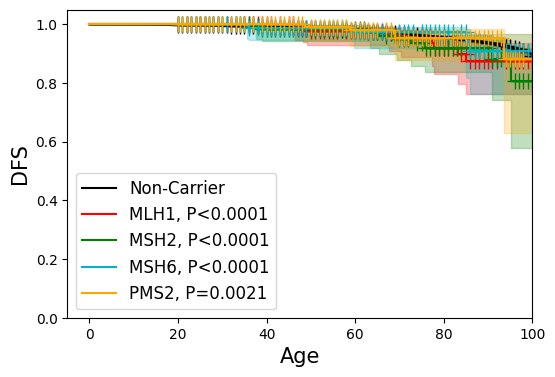

P-value: 0.17978560685361444
Comparison between MSH2 and MLH1: p = 0.8675713377611476
Comparison between MSH2 and PMS2: p = 0.32646549678767256
Comparison between MSH2 and MSH6: p = 0.3891828381156395
Comparison between MSH2 and control: p = 0.13221719293930703
Comparison between MLH1 and PMS2: p = 0.38839146197917673
Comparison between MLH1 and MSH6: p = 0.4733975805615348
Comparison between MLH1 and control: p = 0.2063258662818755
Comparison between PMS2 and MSH6: p = 0.8831574429444222
Comparison between PMS2 and control: p = 0.8672512337813437
Comparison between MSH6 and control: p = 0.9549426392708382


In [91]:
data_surv_LSspec = pd.concat([no_cancer_group[['person_id','age','group']], crc[['person_id','group','age_at_diag']]])
stat = plot_surv(data_surv_LSspec, p4 = 'P=0.0021')

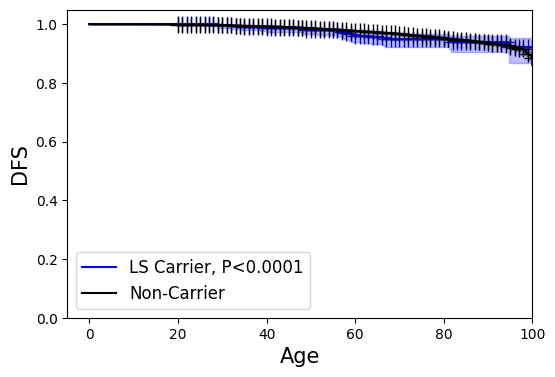

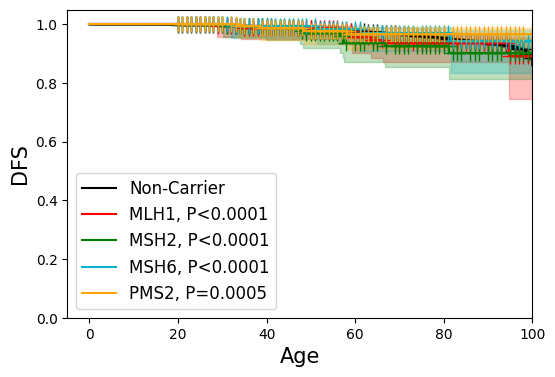

P-value: 0.5506836199609628
Comparison between MSH2 and MLH1: p = 0.6281988980695854
Comparison between MSH2 and PMS2: p = 0.14575167547361118
Comparison between MSH2 and MSH6: p = 0.20599599595742774
Comparison between MSH2 and control: p = 0.1289145570656759
Comparison between MLH1 and PMS2: p = 0.32721253483265295
Comparison between MLH1 and MSH6: p = 0.4033176496017309
Comparison between MLH1 and control: p = 0.5359572024090499
Comparison between PMS2 and MSH6: p = 0.8956868158090419
Comparison between PMS2 and control: p = 0.5554472183650148
Comparison between MSH6 and control: p = 0.6691263550551112


In [92]:
data_surv_LSspec = pd.concat([no_cancer_group[['person_id','age','group']], ue[['person_id','group','age_at_diag']]])
stat = plot_surv(data_surv_LSspec, p4 = 'P=0.0005')

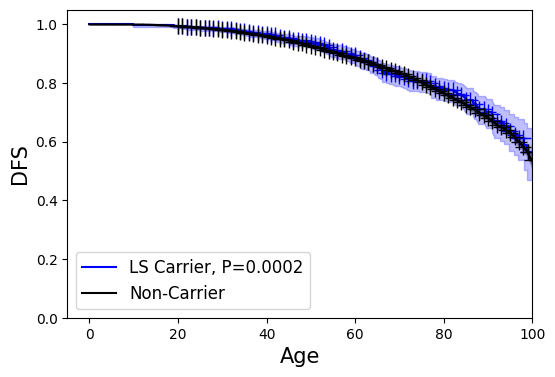

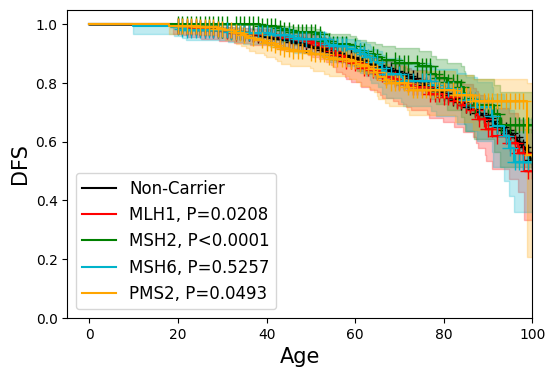

P-value: 0.564207738575934
Comparison between MSH2 and MLH1: p = 0.11036256083826598
Comparison between MSH2 and PMS2: p = 0.4286269208274517
Comparison between MSH2 and MSH6: p = 0.308116645264333
Comparison between MSH2 and control: p = 0.13704108268856804
Comparison between MLH1 and PMS2: p = 0.4589788995369751
Comparison between MLH1 and MSH6: p = 0.5626873468031974
Comparison between MLH1 and control: p = 0.46426491686524907
Comparison between PMS2 and MSH6: p = 0.8968400630341484
Comparison between PMS2 and control: p = 0.7504146588314726
Comparison between MSH6 and control: p = 0.8881008307485861


In [93]:
data_surv_LSspec = pd.concat([no_cancer_group[['person_id','age','group']], others[['person_id','group','age_at_diag']]])
stat = plot_surv(data_surv_LSspec, p = 'P=0.0002', p1 = 'P=0.0208', p2 = 'P<0.0001', p3 = 'P=0.5257', p4 = 'P=0.0493')

# LS fam

In [94]:
def plot_surv(dat, p ='P<0.0001', p1 = 'P<0.0001', p2= 'P<0.0001', p3= 'P<0.0001', p4= 'P<0.0001'):
    lst = list(dat['age_at_diag'])
    event = [1 if not np.isnan(x) else 0 for x in lst]

    time2event = [a2 if not np.isnan(a2) else a1 for a1, a2 in zip(dat['age'], dat['age_at_diag'])]

    dat['event'] = event
    dat['time_to_event'] = time2event

    plt.figure(figsize=(6,4))

    mask_ls = dat['fam_yes'] == 'yes'
    kmf.fit(dat['time_to_event'][mask_ls], event_observed=dat['event'][mask_ls], label='With family history' +', '+p)
    ax = kmf.plot(ci_show=True, show_censors = True, ci_legend = True, color = 'b')

    # # For non-carriers
    mask_non_carrier = dat['fam_yes'] == 'no'
    kmf.fit(dat['time_to_event'][mask_non_carrier], event_observed=dat['event'][mask_non_carrier], label='Unknown family history')
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color ='k')

    plt.ylabel("DFS", fontsize = 15)
    plt.xlabel("Age", fontsize = 15)
    plt.xlim([-5,100])
    plt.ylim([0,1.05])

    plt.legend(fontsize = 12)
    plt.show()
    
    results_ = logrank_test(dat['time_to_event'][mask_ls], dat['time_to_event'][mask_non_carrier], 
                       event_observed_A=dat['event'][mask_ls], event_observed_B=dat['event'][mask_non_carrier])

    plt.figure(figsize=(6,4))

    # # For non-carriers
    mask_non_carrier = dat['fam_yes'] == 'no'
    kmf.fit(dat['time_to_event'][mask_non_carrier], event_observed=dat['event'][mask_non_carrier], label='Unknown family history')
    ax = kmf.plot(ci_show=True, show_censors=True, ci_legend=True, color ='k')

    dat = dat[dat['fam_yes'] == 'yes']
    mask_mlh1 = dat['group'] == 'MLH1'
    kmf.fit(dat['time_to_event'][mask_mlh1], event_observed=dat['event'][mask_mlh1], label='MLH1' +', '+p1)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[0])

    mask_msh2 =  dat['group'] == 'MSH2'
    kmf.fit(dat['time_to_event'][mask_msh2], event_observed=dat['event'][mask_msh2], label='MSH2' +', '+p2)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[1])

    mask_msh6 =  dat['group'] == 'MSH6'
    kmf.fit(dat['time_to_event'][mask_msh6], event_observed=dat['event'][mask_msh6], label='MSH6' +', '+p3)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[2])

    mask_pms2 =  dat['group'] == 'PMS2'
    kmf.fit(dat['time_to_event'][mask_pms2], event_observed=dat['event'][mask_pms2], label='PMS2' +', '+p4)
    kmf.plot(ax=ax, ci_show=True, show_censors=True, ci_legend=True, color = col[3])

    plt.ylabel("DFS", fontsize = 15)
    plt.xlabel("Age", fontsize = 15)
    plt.xlim([-5,100])
    plt.ylim([0,1.05])

    plt.legend(fontsize = 12)
    plt.show()
    
    p_value = results_.p_value
    print(f"P-value: {p_value}")
    
    df = dat.copy(deep = True)
    df = df[df['fam_yes']=='yes']
    genes = df['group'].unique()
    for (gene1, gene2) in combinations(genes, 2):
        results = logrank_test(
            df['time_to_event'][df['group'] == gene1], 
            df['time_to_event'][df['group'] == gene2], 
            event_observed_A=df['event'][df['group'] == gene1], 
            event_observed_B=df['event'][df['group'] == gene2]
        )
        print(f"Comparison between {gene1} and {gene2}: p = {results.p_value}")
    return results_

### all cancer

In [96]:
# bucket = os.getenv("WORKSPACE_BUCKET")
save_path = '../datasets/LS_fam.csv'
LSfam = pd.read_csv(save_path)

save_path = '../datasets/nonLS_fam.csv'
nonLSfam = pd.read_csv(save_path)

In [97]:
fam_yes = pd.concat([LSfam, nonLSfam])
fam_yes['fam_yes'] = 'yes'

In [98]:
len(fam_yes)

2000

In [99]:
data_surv_fam = data_surv.merge(fam_yes[['person_id','fam_yes']], on = 'person_id', how = 'outer')

In [100]:
data_surv_fam['fam_yes'] = data_surv_fam['fam_yes'].fillna('no')

In [101]:
Counter(data_surv_fam['fam_yes'])

Counter({'no': 48284, 'yes': 2000})

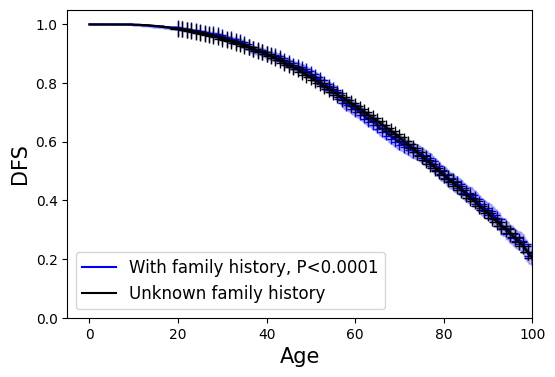

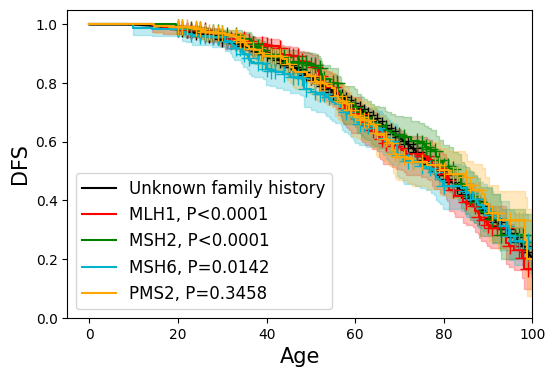

P-value: 0.5090183131344521
Comparison between MSH2 and PMS2: p = 0.9520022273228279
Comparison between MSH2 and MLH1: p = 0.22261832977878546
Comparison between MSH2 and MSH6: p = 0.274453983621466
Comparison between MSH2 and control: p = 0.6899227414798241
Comparison between PMS2 and MLH1: p = 0.41456308940708386
Comparison between PMS2 and MSH6: p = 0.40059289432033707
Comparison between PMS2 and control: p = 0.9951527163244837
Comparison between MLH1 and MSH6: p = 0.9898740881117442
Comparison between MLH1 and control: p = 0.3828866900156407
Comparison between MSH6 and control: p = 0.3471465730860437


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.44 0.51      0.97

In [103]:
plot_surv(data_surv_fam, p3='P=0.0142', p4='P=0.3458')

### LS cancer

In [104]:
data_surv_LS_fam = data_surv_fam.merge(data_surv_LS[['person_id']], on = 'person_id', how = 'inner')

In [105]:
# data_surv_LS_fam

In [106]:
# Counter(data_surv_LS_fam['category'])

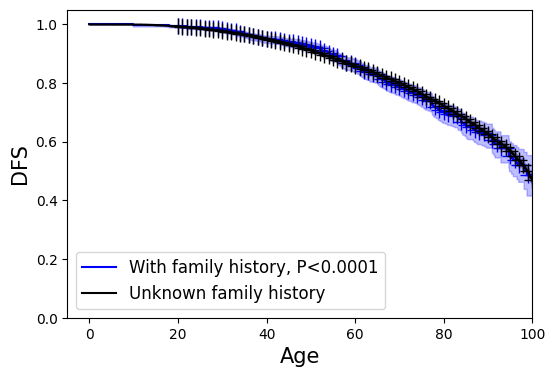

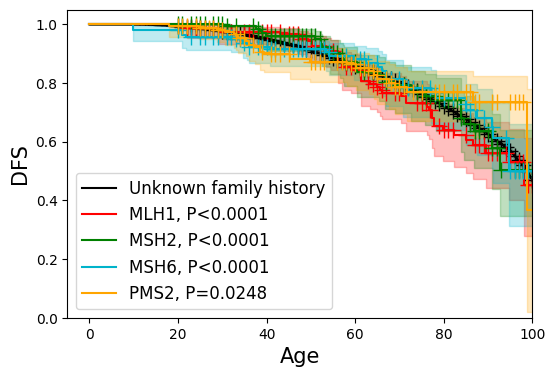

P-value: 0.7582461421272859
Comparison between PMS2 and MSH6: p = 0.5180720484773484
Comparison between PMS2 and MLH1: p = 0.21729758691880108
Comparison between PMS2 and MSH2: p = 0.5174855021919769
Comparison between PMS2 and control: p = 0.2835857676641671
Comparison between MSH6 and MLH1: p = 0.660806651877681
Comparison between MSH6 and MSH2: p = 0.9901009836882672
Comparison between MSH6 and control: p = 0.6174432940176593
Comparison between MLH1 and MSH2: p = 0.4711865881543683
Comparison between MLH1 and control: p = 0.7771516813739825
Comparison between MSH2 and control: p = 0.5458623484324098


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.09 0.76      0.40

In [107]:
plot_surv(data_surv_LS_fam, p4 = 'P=0.0248')

In [108]:
test = data_surv_LS_fam[~pd.isna(data_surv_LS_fam['category'])]
Counter(test['fam_yes'])

Counter({'no': 7021, 'yes': 295})